# Chat With Your SQL Database

_by Tuana Celik ([X](https://twitter.com/tuanacelik), [LI](https://www.linkedin.com/in/tuanacelik/))_

In this example, we are querying a SQL Database!

_Resources_:
- [Haystack Docs](https://docs.haystack.deepset.ai?utm_campaign=developer-relations&utm_source=sql-agent&utm_medium=colab)
- [Haystack Tutorials](https://haystack.deepset.ai/tutorials?utm_campaign=developer-relations&utm_source=sql-agent&utm_medium=colab)
- [Haystack Repo](https://github.com/deepset-ai/haystack)

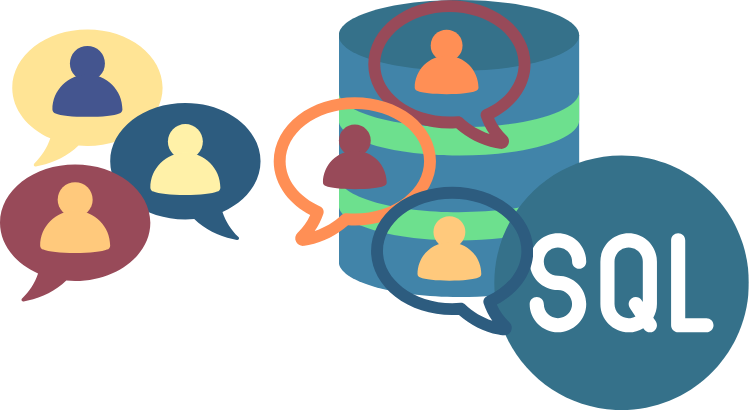

## Install dependencies

For this demo, we're using SQLite.

The first few code cells in this section fetchers a CSV file on 'Absenteeism' and creates a SQL table from it

In [ ]:
!pip install git+https://github.com/deepset-ai/haystack.git@main#egg=haystack-ai

In [27]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"

# download the file
urlretrieve(url, "Absenteeism_at_work_AAA.zip")

print("Extracting the Absenteeism at work dataset...")
# Extract the CSV file
with ZipFile("Absenteeism_at_work_AAA.zip", 'r') as zf:
    zf.extractall()

# Check the extracted CSV file name (in this case, it's "Absenteeism_at_work.csv")
csv_file_name = "Absenteeism_at_work.csv"

print("Cleaning up the Absenteeism at work dataset...")
# Data clean up
df = pd.read_csv(csv_file_name, sep=";")
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')

Extracting the Absenteeism at work dataset...
Cleaning up the Absenteeism at work dataset...


In [97]:
columns = df.columns.to_list()
columns = ', '.join(columns)
columns

'ID, Reason_for_absence, Month_of_absence, Day_of_the_week, Seasons, Transportation_expense, Distance_from_Residence_to_Work, Service_time, Age, Work_load_Average_day_, Hit_target, Disciplinary_failure, Education, Son, Social_drinker, Social_smoker, Pet, Weight, Height, Body_mass_index, Absenteeism_time_in_hours'

In [38]:
import sqlite3

connection = sqlite3.connect('absenteeism.db')
print("Opened database successfully");

connection.execute('''CREATE TABLE IF NOT EXISTS absenteeism (ID integer,
                        Reason_for_absence integer,
                        Month_of_absence integer,
                        Day_of_the_week integer,
                        Seasons integer,
                        Transportation_expense integer,
                        Distance_from_Residence_to_Work integer,
                        Service_time integer,
                        Age integer,
                        Work_load_Average_day_ integer,
                        Hit_target integer,
                        Disciplinary_failure integer,
                        Education integer,
                        Son integer,
                        Social_drinker integer,
                        Social_smoker integer,
                        Pet integer,
                        Weight integer,
                        Height integer,
                        Body_mass_index integer,
                        Absenteeism_time_in_hours integer);''')
connection.commit()

Opened database successfully


In [40]:
df.to_sql('absenteeism', connection, if_exists='replace', index = False)

740

In [41]:
connection.close()

## Create a SQL Query Component

Here, we're creating a custom component called `SQLQuery`, this way, we can use it in our Haystack pipeline like any other component (like a retriever, generator etc). This component does just one thing:
- Accepts `queries` which are SQL queries
- Queries the database with those SQL queries and returns the result from the database.

In [123]:
from typing import List
from haystack import component

@component
class SQLQuery:

    def __init__(self, sql_database: str):
      self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        for query in queries:
          result = pd.read_sql(query, self.connection)
          results.append(f"{result}")
        return {"results": results, "queries": queries}

### Try the SQLQuery Component

In [124]:
sql_query = SQLQuery('absenteeism.db')

In [125]:
result = sql_query.run(queries=['SELECT Age, SUM(Absenteeism_time_in_hours) as Total_Absenteeism_Hours FROM absenteeism WHERE Disciplinary_failure = 0 GROUP BY Age ORDER BY Total_Absenteeism_Hours DESC LIMIT 3;'])
print(result["results"][0])

   Age  Total_Absenteeism_Hours
0   28                      651
1   33                      538
2   38                      482


## Query A SQL Database with Natural Language

In this section, we're building a simple pipeline that can:
- Accept natural language questions
- Translates those questions into a SQL Query
- Queries our database using the `SQLQuery` component

**Shortcoming:** This pipeline will still run if you ask a completely unrelated question that cannot be answered with the database we have at hand. Observe how the `SQLQuery` component throws an error in these cases.


In [67]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")


OpenAI API Key: ··········


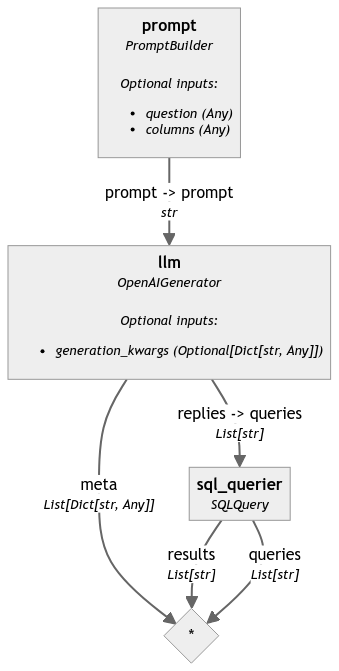

In [126]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")
sql_query = SQLQuery('absenteeism.db')
llm = OpenAIGenerator(model="gpt-4")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_querier", sql_query)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_querier.queries")

# If you want to draw the pipeline, uncomment below 👇
sql_pipeline.show()

In [127]:
result = sql_pipeline.run({"prompt": {"question": "On which days of the week does the average absenteeism time exceed 4 hours?",
                            "columns": columns}})

print(result["sql_querier"]["results"][0])

   Day_of_the_week
0                2
1                3
2                4
3                5
4                6


## Skip for Unrelated Questions: Add a Condition

Now, let's create another pipeline, to avoid having to query the database if the question is unrelated to the information present in the database. For this, we do a few things:
- We modify the prompt to answer with `no_answer` if the question cannot be answered given the database and its `columns`
- We add a conditional router that routes the query to the `SQLQuery` component only if the question was evaluated to be answerable
- We add a `fallback_prompt` and `fallback_llm` to return a statement about the fact that the question cannot be answered, along with reasons. This branch of the pipeline runs only if the question cannot be answered.

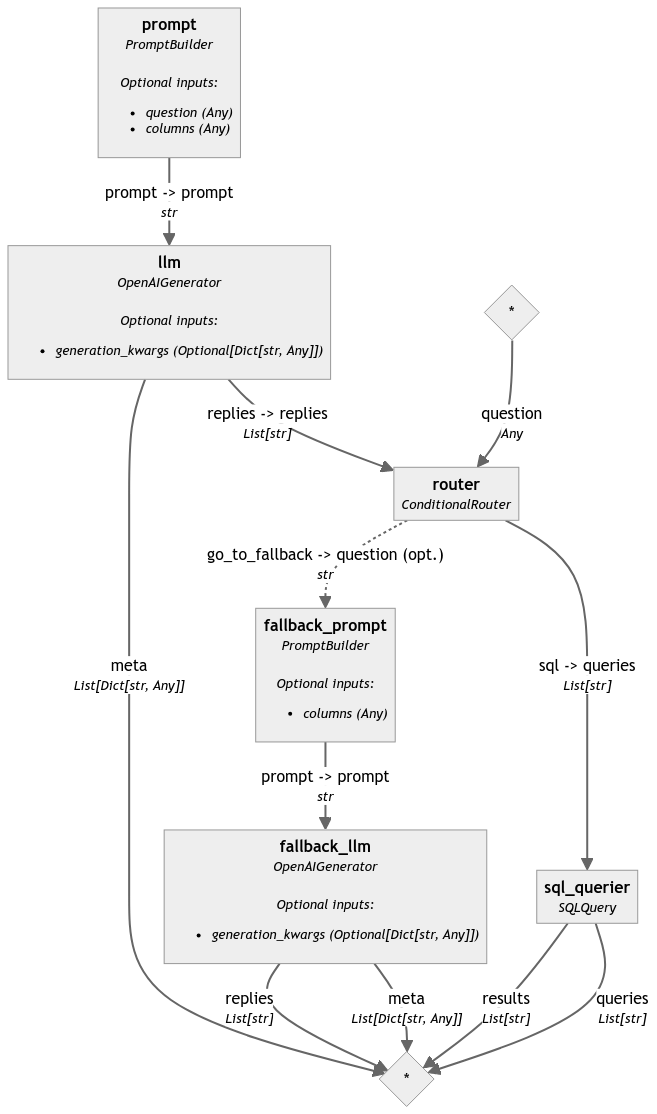

In [135]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.routers import ConditionalRouter

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            If the question cannot be answered given the provided table and columns, return 'no_answer'
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")

llm = OpenAIGenerator(model="gpt-4")
sql_query = SQLQuery('absenteeism.db')

routes = [
     {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies}}",
        "output_name": "sql",
        "output_type": List[str],
    },
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{question}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

fallback_prompt = PromptBuilder(template="""User entered a query that cannot be answerwed with the given table.
                                            The query was: {{question}} and the table had columns: {{columns}}.
                                            Let the user know why the question cannot be answered""")
fallback_llm = OpenAIGenerator(model="gpt-4")

conditional_sql_pipeline = Pipeline()
conditional_sql_pipeline.add_component("prompt", prompt)
conditional_sql_pipeline.add_component("llm", llm)
conditional_sql_pipeline.add_component("router", router)
conditional_sql_pipeline.add_component("fallback_prompt", fallback_prompt)
conditional_sql_pipeline.add_component("fallback_llm", fallback_llm)
conditional_sql_pipeline.add_component("sql_querier", sql_query)

conditional_sql_pipeline.connect("prompt", "llm")
conditional_sql_pipeline.connect("llm.replies", "router.replies")
conditional_sql_pipeline.connect("router.sql", "sql_querier.queries")
conditional_sql_pipeline.connect("router.go_to_fallback", "fallback_prompt.question")
conditional_sql_pipeline.connect("fallback_prompt", "fallback_llm")

#if you want to draw the pipeline, uncomment below 👇

#conditional_sql_pipeline.show()

In [137]:
question = "When is my birthday?"
result = conditional_sql_pipeline.run({"prompt": {"question": question,
                                                  "columns": columns},
                                       "router": {"question": question},
                                       "fallback_prompt": {"columns": columns}})
if 'sql_querier' in result:
  print(result['sql_querier']['results'][0])
elif 'fallback_llm' in result:
  print(result['fallback_llm']['replies'][0])



The query cannot be answered as the provided table does not contain information regarding the user's personal data such as birthdays. The table primarily focuses on absence-related data for presumably work or similar situations. Please provide the relevant data to get the accurate answer.


## Function Calling to Query a SQL Database

Now let's try something a bit more fun. Instead of a component, we are going to procide sql querying as a function. Since we already built it, we can simply wrap our `SQLQuery` component into a function 👇

In [128]:
sql_query = SQLQuery('absenteeism.db')

def sql_query_func(queries: List[str]):
    try:
      result = sql_query.run(queries)
      return {"reply": result["results"][0]}

    except Exception as e:
      reply = f"""There was an error running the SQL Query = {queries}
              The error is {e},
              You should probably try again.
              """
      return {"reply": reply}

### Define Tools

Now, let's provide this function as a tool. Below, we are using OpenAI for demonstration purposes so we abide by their function definition schema 👇

In [129]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "sql_query_func",
            "description": f"This a tool useful to query a SQL table called 'absenteeism' with the following Columns: {columns}",
            "parameters": {
                "type": "object",
                "properties": {
                    "queries": {
                        "type": "array",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                        "items": {
                            "type": "string",
                        }
                    }
                },
                "required": ["question"],
            },
        },
    }
]

### Try The Tool

In [130]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    ),
    ChatMessage.from_user("On which days of the week does the average absenteeism time exceed 4 hours??"),
]

chat_generator = OpenAIChatGenerator(model="gpt-4", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})
print(response)


{'replies': [ChatMessage(content='[{"index": 0, "id": "call_fRYwYg6iAqroHwYzPD6UxOVg", "function": {"arguments": "{\\n  \\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) AS Average_Absenteeism_Hours FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 4\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {}})]}


In [131]:
import json

## Parse function calling information
function_call = json.loads(response["replies"][0].text)[0]
function_name = function_call["function"]["name"]
function_args = json.loads(function_call["function"]["arguments"])
print("Function Name:", function_name)
print("Function Arguments:", function_args)

## Find the correspoding function and call it with the given arguments
available_functions = {"sql_query_func": sql_query_func}
function_to_call = available_functions[function_name]
function_response = function_to_call(**function_args)
print("Function Response:", function_response)


Function Name: sql_query_func
Function Arguments: {'queries': ['SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) AS Average_Absenteeism_Hours FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 4']}
Function Response: {'reply': '   Day_of_the_week  Average_Absenteeism_Hours\n0                2                   9.248447\n1                3                   7.980519\n2                4                   7.147436\n3                5                   4.424000\n4                6                   5.125000'}


## Build a Chat with SQL App

First, let's install Gradio, we will use that for our mini app

In [ ]:
!pip install gradio

In [132]:
import gradio as gr
import json

from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

chat_generator = OpenAIChatGenerator(model="gpt-4")
response = None
messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    )
]


def chatbot_with_fc(message, history):
    available_functions = {"sql_query_func": sql_query_func}
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

    while True:
        # if OpenAI response is a tool call
        if response and response["replies"][0].meta["finish_reason"] == "tool_calls":
            function_calls = json.loads(response["replies"][0].text)
            for function_call in function_calls:
                ## Parse function calling information
                function_name = function_call["function"]["name"]
                function_args = json.loads(function_call["function"]["arguments"])

                ## Find the correspoding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)
                ## Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=function_response['reply'], name=function_name))
                response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].text


In [133]:
demo = gr.ChatInterface(
    fn=chatbot_with_fc,
    examples=[
        "Find the top 3 ages with the highest total absenteeism hours, excluding disciplinary failures",
        "On which days of the week does the average absenteeism time exceed 4 hours?",
        "Who lives in London?",
    ],
    title="Chat with your SQL Database",
)

In [134]:
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://83eb0414c1916d8ee7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ChatMessage(content='[{"id": "call_Uu8QXlIsJfYCULD4Q0bEcAtP", "function": {"arguments": "{\\n  \\"queries\\": [\\n    \\"SELECT Age, SUM(Absenteeism_time_in_hours) as Total_Absenteeism_Hours FROM absenteeism WHERE Disciplinary_failure = 0 GROUP BY Age ORDER BY Total_Absenteeism_Hours DESC LIMIT 3\\"\\n  ]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 68, 'prompt_tokens': 207, 'total_tokens': 275}})
   Age  Total_Absenteeism_Hours
0   28                      651
1   33                      538
2   38                      482
ChatMessage(content='[{"id": "call_t8bjUHMvHHrXReB2qm3iVkNF", "function": {"arguments": "{\\n\\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as average_absenteeism_time FROM absenteeism GROUP BY Day_of_the_week HAVING average_absenteeism_time > 4\\"]\\n}", "name": "sql_query_func